# Emotional Valence Prediction

In [1]:
# path settings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# set up autoreload
%load_ext autoreload
%autoreload 2

## Static methods - 7 days of data considered

In this example, to form the classifier input features, we consider the previous 7 days of observations.
We compare the cases of using the imputed data, the posteriors and the two concatenated as input features for a Balanced
Random Forest Classifier. Grid-search is performed for hyper-parameter tuning in each case.

### Imputation and feature extraction

Here we apply the 7-component MM to perform the imputation and feature extraction. The same approach can be followed when
using a HMM model as well.

In [2]:
import pandas as pd
import multiprocessing as mp
from src.utils.data_utils import load_and_impute

# load training and test data
df_train = pd.read_csv(PATH_TO_TRAIN_DATA)
df_test = pd.read_csv(PATH_TO_TRAIN_DATA)

# list of input features
data_columns = ['steps_total', 'distance', 'sleep', 'app_usage', 'home_cluster', 'clusters_count', 'practiced_sport']

# impute missing values and get posteriors
hmm_path = PATH_TO_HMM
df_train_imp = load_and_impute(df_train, data_columns+['valence'], hmm_path, n_processes=mp.cpu_count(), dt=7, mix_mod=True)
df_test_imp = load_and_impute(df_test, data_columns+['valence'], hmm_path, n_processes=mp.cpu_count(), dt=7, mix_mod=True)

# list of classifier feature names
feature_columns = [col+"_t-" + str(int(t)) if t > 0 else col+"_t"
                   for t in range(6,-1,-1) for col in data_columns]
state_columns = ["p(s_" + str(int(i)) + "|x_{t-6:t-" + str(int(t)) + "})" if t > 0 else "p(s_" + str(int(i)) + "|x_{t-6:t})"
                 for t in range(6,-1,-1) for i in range(7)]

### Prediction on raw data
#### Train-test sets

In [3]:
X_train, y_train = (df_train_imp[feature_columns].values, df_train_imp.valence.values.ravel())
X_test, y_test = (df_test_imp[feature_columns].values, df_test_imp.valence.values.ravel())

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (8847, 49)
y_train shape: (8847,)
X_test shape: (3069, 49)
y_test shape: (3069,)


##### Label distributions in the train - test sets

Text(0.5, 1.0, 'Test set')

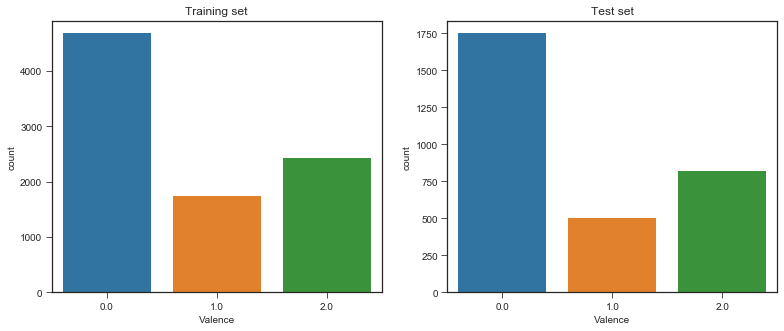

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.countplot(x='Valence', data=pd.DataFrame(data = {'Valence':y_train}), ax=ax1)
ax1.set_title('Training set')

sns.countplot(x='Valence', data=pd.DataFrame(data = {'Valence':y_test}), ax=ax2)
ax2.set_title('Test set')

#### Balanced Random Forest Classifier
##### Training

In [5]:
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 30, 50, 75, 100],
    'max_features': [2, 3, 4, 6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 50, 100, 200],
    'class_weight' : ['balanced', 'balanced_subsample']
}

brf_clf = GridSearchCV(BalancedRandomForestClassifier(random_state=0, n_jobs=-1),
                       param_grid, scoring='f1_weighted', n_jobs = -1).fit(X_train, y_train)

print(brf_clf.best_estimator_)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                               max_features=3, min_samples_leaf=3,
                               min_samples_split=10, n_estimators=200,
                               n_jobs=-1, random_state=0)


##### Evaluation
* *Training set*

In [6]:
from sklearn.metrics import classification_report

y_pred_tr = brf_clf.predict(X_train)
y_score_tr = brf_clf.predict_proba(X_train)
print(classification_report(y_train, y_pred_tr,
                            target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.88      0.69      0.77      4683
     Neutral       0.70      0.88      0.78      1738
    Positive       0.66      0.81      0.73      2426

    accuracy                           0.76      8847
   macro avg       0.75      0.79      0.76      8847
weighted avg       0.78      0.76      0.76      8847



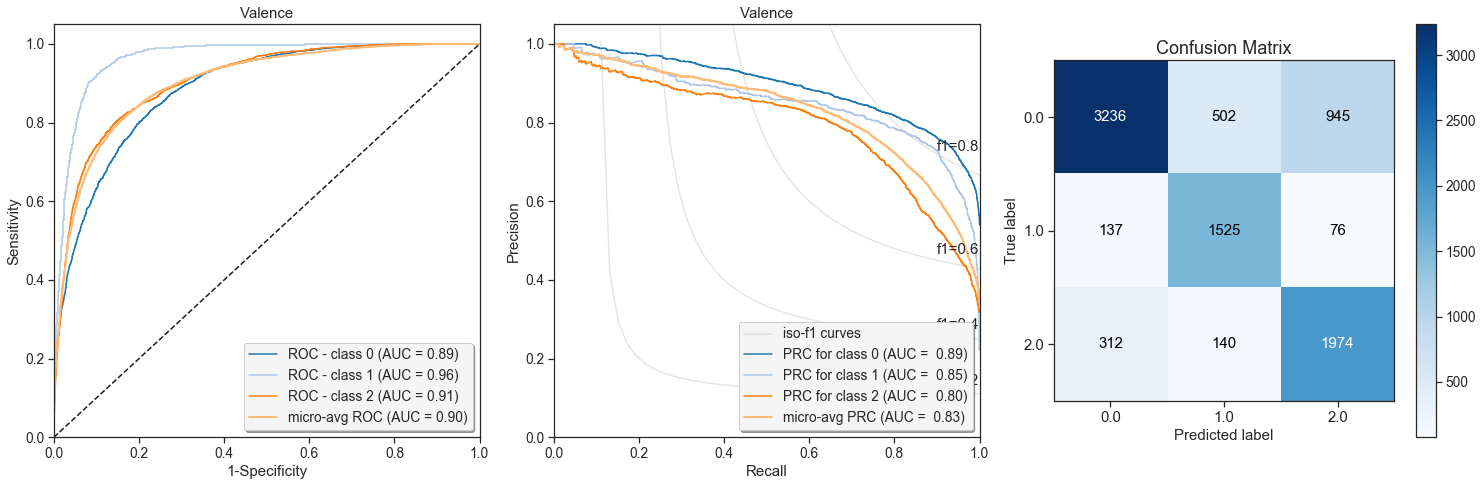

In [7]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_train, y_pred_tr, y_score_tr, figsize=(21, 7), label='Valence')

* *Test set*

In [8]:
from sklearn.metrics import classification_report

y_pred_test = brf_clf.predict(X_test)
y_score_test = brf_clf.predict_proba(X_test)
print(classification_report(y_test, y_pred_test,
                            target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.66      0.36      0.47      1749
     Neutral       0.16      0.29      0.21       502
    Positive       0.36      0.53      0.43       818

    accuracy                           0.40      3069
   macro avg       0.39      0.39      0.37      3069
weighted avg       0.50      0.40      0.42      3069



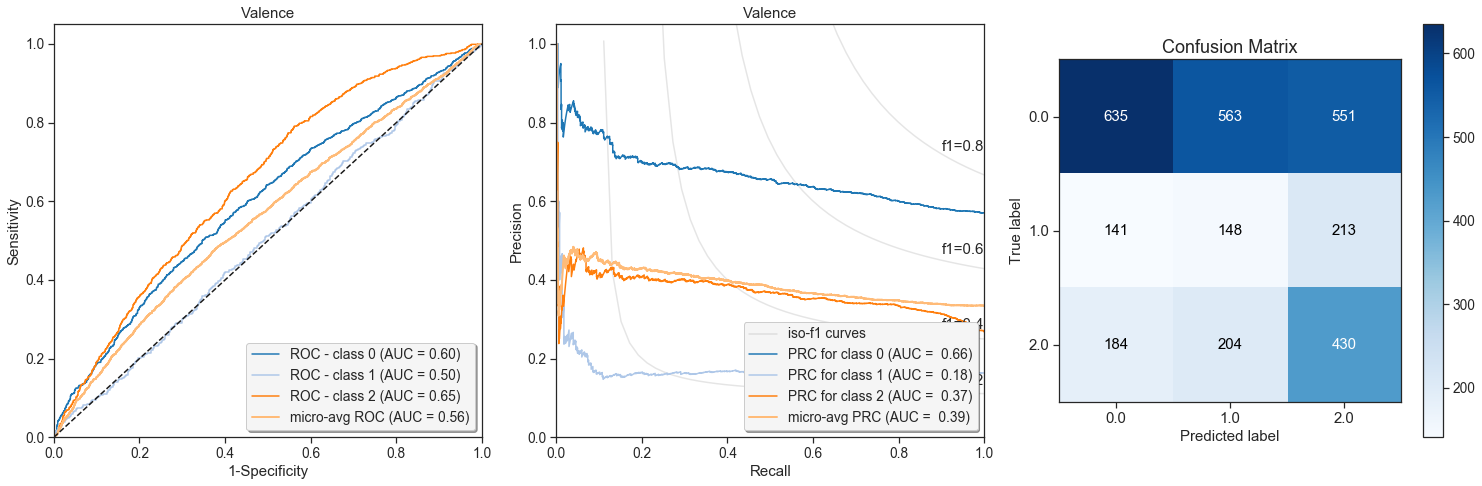

In [9]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_test, y_pred_test, y_score_test, figsize=(21, 7), label='Valence')

##### Feature importance analysis

  0%|          | 0/50 [00:00<?, ?it/s]

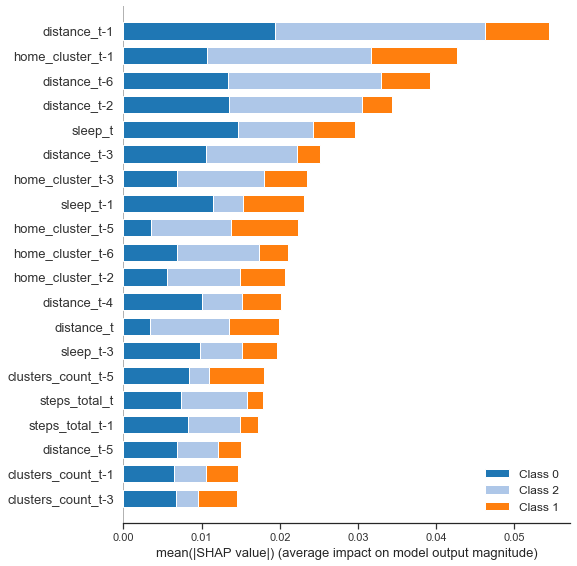

In [10]:
from src.utils.visualisation_utils import create_feature_importance_plot

create_feature_importance_plot(df_train_imp, df_test_imp, brf_clf, feature_columns,50)

### Prediction on MM posteriors
#### Train-test sets

In [11]:
X_train, y_train = (df_train_imp[state_columns].values, df_train_imp.valence.values.ravel())
X_test, y_test = (df_test_imp[state_columns].values, df_test_imp.valence.values.ravel())

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (8847, 49)
y_train shape: (8847,)
X_test shape: (3069, 49)
y_test shape: (3069,)


#### Balanced Random Forest Classifier
##### Training

In [12]:
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 30, 50, 75, 100],
    'max_features': [2, 3, 4, 6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 50, 100, 200],
    'class_weight' : ['balanced', 'balanced_subsample']
}

brf_clf = GridSearchCV(BalancedRandomForestClassifier(random_state=0, n_jobs=-1),
                       param_grid, scoring='f1_weighted', n_jobs = -1).fit(X_train, y_train)

print(brf_clf.best_estimator_)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                               max_features=2, min_samples_leaf=4,
                               min_samples_split=8, n_estimators=200, n_jobs=-1,
                               random_state=0)


##### Evaluation
* *Training set*

In [13]:
from sklearn.metrics import classification_report

y_pred_tr = brf_clf.predict(X_train)
y_score_tr = brf_clf.predict_proba(X_train)
print(classification_report(y_train, y_pred_tr,
                            target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.83      0.63      0.71      4683
     Neutral       0.54      0.62      0.58      1738
    Positive       0.55      0.75      0.64      2426

    accuracy                           0.66      8847
   macro avg       0.64      0.67      0.64      8847
weighted avg       0.70      0.66      0.67      8847



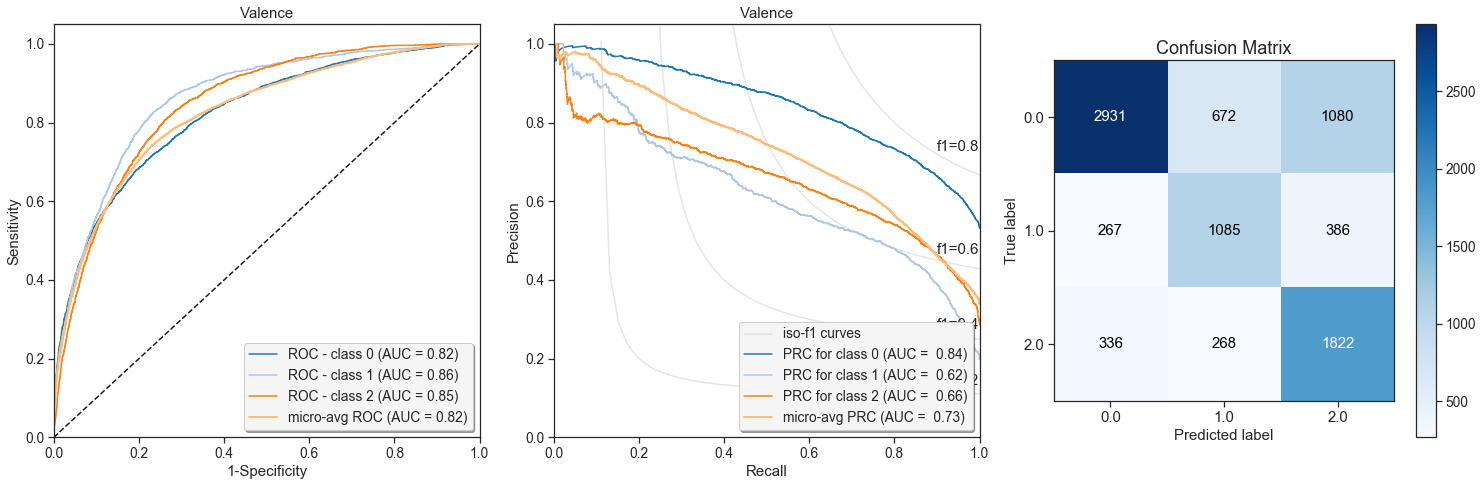

In [14]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_train, y_pred_tr, y_score_tr, figsize=(21, 7), label='Valence')

* *Test set*

In [15]:
from sklearn.metrics import classification_report

y_pred_test = brf_clf.predict(X_test)
y_score_test = brf_clf.predict_proba(X_test)
print(classification_report(y_test, y_pred_test,
                            target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.80      0.58      0.68      1749
     Neutral       0.33      0.35      0.34       502
    Positive       0.45      0.69      0.54       818

    accuracy                           0.57      3069
   macro avg       0.53      0.54      0.52      3069
weighted avg       0.63      0.57      0.59      3069



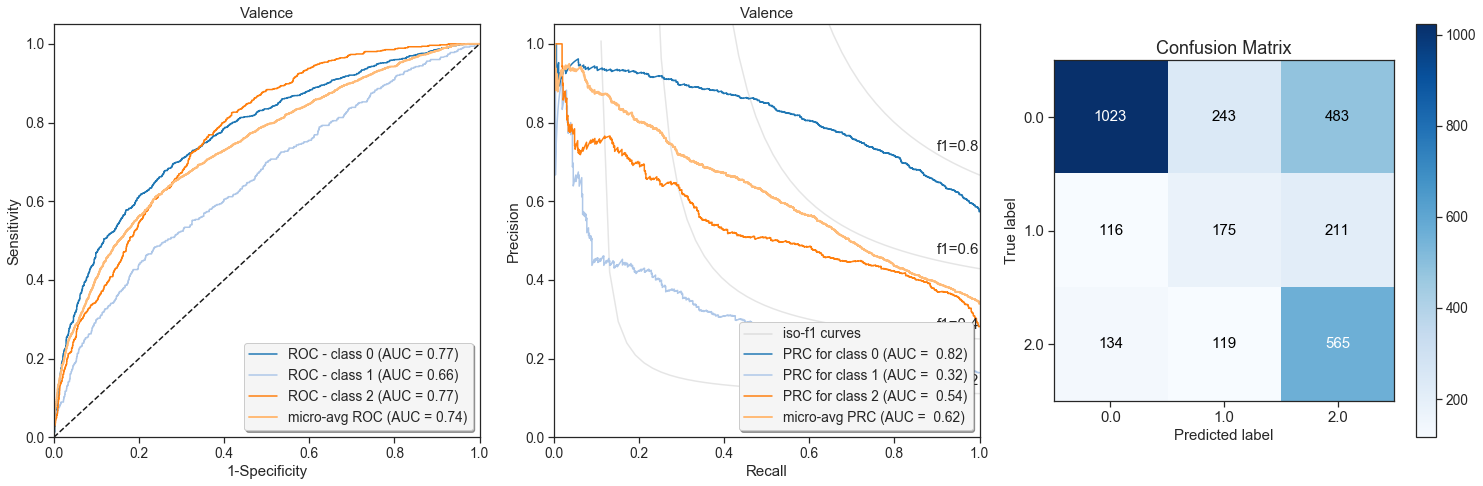

In [16]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_test, y_pred_test, y_score_test, figsize=(21, 7), label='Valence')

##### Feature importance analysis

  0%|          | 0/50 [00:00<?, ?it/s]

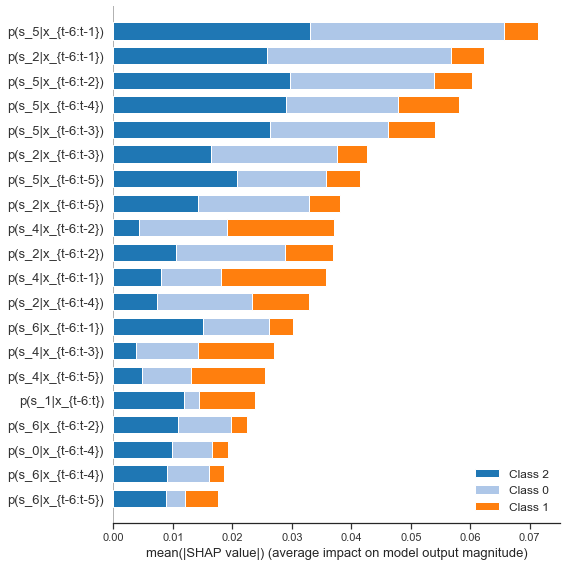

In [17]:
from src.utils.visualisation_utils import create_feature_importance_plot

create_feature_importance_plot(df_train_imp, df_test_imp, brf_clf, state_columns, 50)

### Prediction on raw data concatenated with MM posteriors
#### Train-test sets

In [18]:
X_train, y_train = (df_train_imp[feature_columns+state_columns].values, df_train_imp.valence.values.ravel())
X_test, y_test = (df_test_imp[feature_columns+state_columns].values, df_test_imp.valence.values.ravel())

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (8847, 98)
y_train shape: (8847,)
X_test shape: (3069, 98)
y_test shape: (3069,)


#### Balanced Random Forest Classifier
##### Training

In [19]:
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 30, 50, 75, 100],
    'max_features': [2, 3, 4, 6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 50, 100, 200],
    'class_weight' : ['balanced', 'balanced_subsample']
}

brf_clf = GridSearchCV(BalancedRandomForestClassifier(random_state=0, n_jobs=-1),
                       param_grid, scoring='f1_weighted', n_jobs = -1).fit(X_train, y_train)

print(brf_clf.best_estimator_)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                               max_features=6, min_samples_leaf=4,
                               min_samples_split=12, n_estimators=200,
                               n_jobs=-1, random_state=0)


##### Evaluation
* *Training set*

In [20]:
from sklearn.metrics import classification_report

y_pred_tr = brf_clf.predict(X_train)
y_score_tr = brf_clf.predict_proba(X_train)
print(classification_report(y_train, y_pred_tr,
                            target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.96      0.76      0.85      4683
     Neutral       0.77      0.97      0.86      1738
    Positive       0.75      0.92      0.83      2426

    accuracy                           0.84      8847
   macro avg       0.83      0.88      0.84      8847
weighted avg       0.87      0.84      0.84      8847



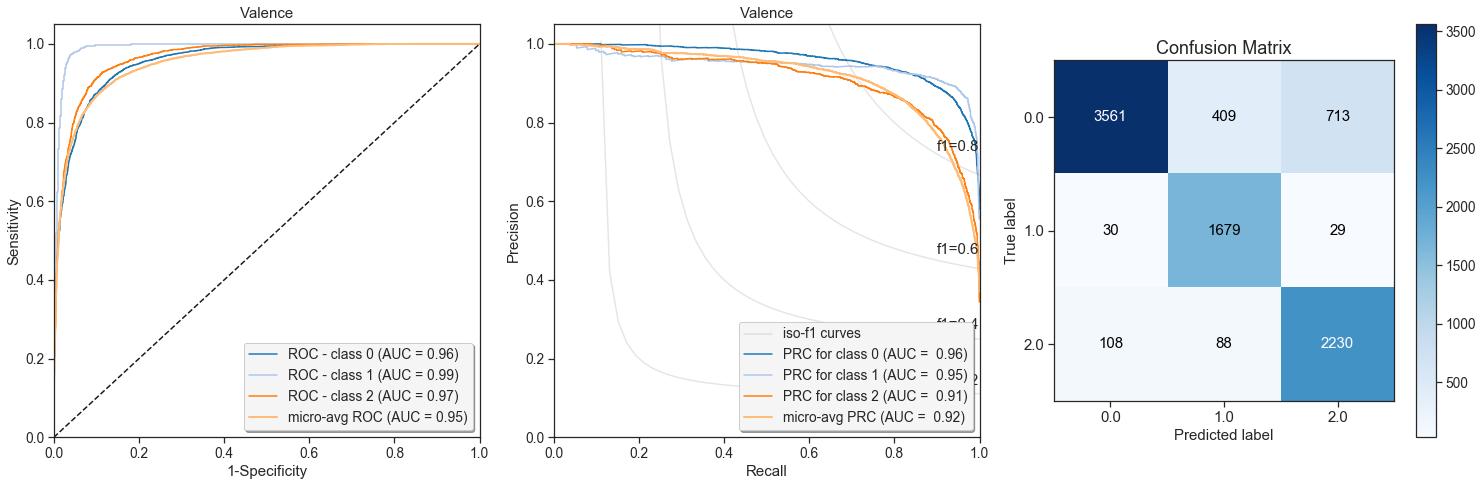

In [21]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_train, y_pred_tr, y_score_tr, figsize=(21, 7), label='Valence')

* *Test set*

In [22]:
from sklearn.metrics import classification_report

y_pred_test = brf_clf.predict(X_test)
y_score_test = brf_clf.predict_proba(X_test)
print(classification_report(y_test, y_pred_test,
                            target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.80      0.53      0.63      1749
     Neutral       0.25      0.36      0.29       502
    Positive       0.46      0.67      0.55       818

    accuracy                           0.54      3069
   macro avg       0.50      0.52      0.49      3069
weighted avg       0.62      0.54      0.56      3069



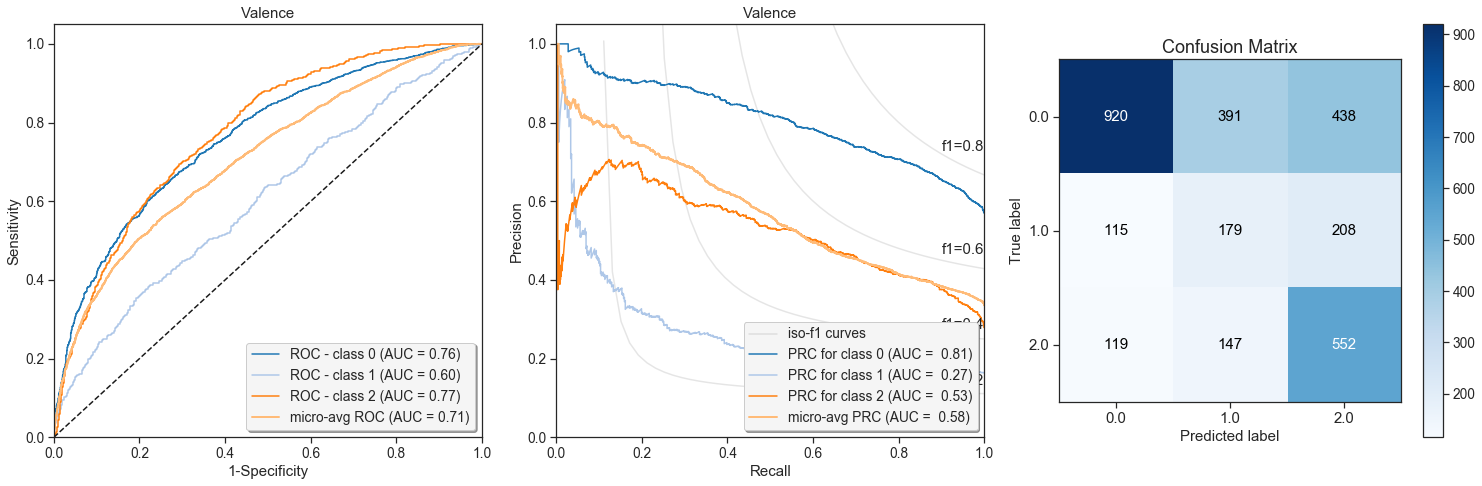

In [23]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_test, y_pred_test, y_score_test, figsize=(21, 7), label='Valence')

##### Feature importance analysis

  0%|          | 0/50 [00:00<?, ?it/s]

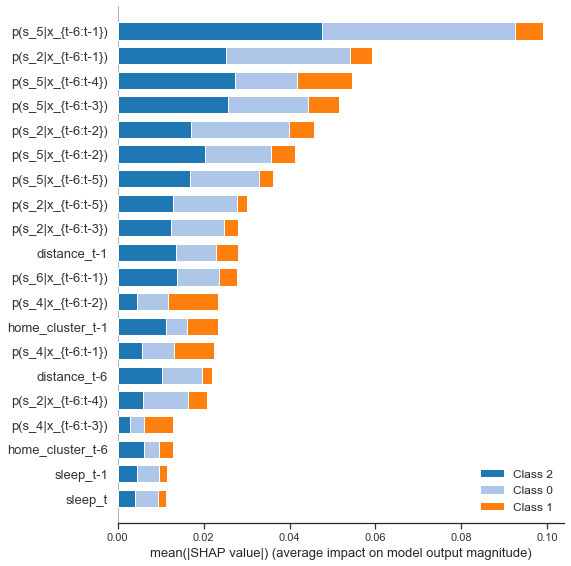

In [24]:
from src.utils.visualisation_utils import create_feature_importance_plot

create_feature_importance_plot(df_train_imp, df_test_imp, brf_clf, feature_columns+state_columns, 50)

## Temporal models - 1-month sequences

Contains the training and evaluation with sequence lengths of 30 days training a single layer RNN with GRU cells.

### Creating Training, Validation and Test Sets

In [2]:
from src.utils.data_utils import get_patient_dfs

# define list with columns of interest
eB2_columns = ['steps_total', 'distance', 'sleep', 'app_usage', 'home_cluster', 'clusters_count', 'practiced_sport']
score_column = 'valence'
score_columns = [score_column]

# defined the other necessary parameters
seq_len = 30
miss_len = 21
pad_token = -1

# read data from csv files
data_path = PATH_TO_TRAIN_TEST_DATA
df_train, df_test = get_patient_dfs(data_path, eB2_columns, score_columns,
                                    seq_len=seq_len, miss_len=miss_len, pad_token=pad_token, pre_pad=True)

### Prediction on raw data

#### DataLoaders and Batching

In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from src.utils.data_utils import VariableLengthCollator

# data loaders and batching
batch_size = 96

# create custom collator function
hmm_path = PATH_TO_HMM
my_collator = VariableLengthCollator(hmm_path, pad_token, add_posteriors=False)

split_idx = int(0.9*len(df_train[0]))
train_loader = DataLoader(TensorDataset(df_train[0][:split_idx, :, :], df_train[1][:split_idx, :, :], df_train[2][:split_idx]),
                          shuffle=True, batch_size=batch_size, collate_fn=my_collator, drop_last=True, num_workers=16)
valid_loader = DataLoader(TensorDataset(df_train[0][split_idx:, :, :], df_train[1][split_idx:, :, :], df_train[2][split_idx:]),
                          shuffle=True, batch_size=batch_size, collate_fn=my_collator, drop_last=True, num_workers=16)
test_loader = DataLoader(TensorDataset(*df_test), batch_size=len(df_test[0]), collate_fn=my_collator, num_workers=16)

#### 1-layer, unidirectional GRU

##### Defining the Network

In [27]:
from src.models.cls.rnn_classifier import RNNExtended

# define dictionary of hyperparameters for the model
hparams = {
    "input_dim" : 7,
    "hidden_dim" : 64,
    "n_layers" : 1,
    "bidirectional" : False,
    "output_dim" : 3,
    "cell_type" : "GRU",
    "drop_prob" : 0,
    "learning_rate" : 0.001,
    "weight_decay" : 0,
    "max_nb_epochs" : 50,
    "clip" : 0.5,
    "pad_token" : pad_token,
}

# create a complete NN
model = RNNExtended(hparams)

print(model)

RNNExtended(
  (rnn): GRU(7, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


##### Training

In [29]:
model_path = PATH_TO_RNNs +'gru_1l_no_post_'
model.train_loop(train_loader, valid_loader, print_every=10, model_path=model_path)
torch.save(model, model_path+'model.pt')

Epoch: 1	 Validation loss decreased (inf --> 1.0127).  Saving models ...
Epoch: 2	 Validation loss decreased (1.0127 --> 0.9818).  Saving models ...
Epoch: 3	 Validation loss decreased (0.9818 --> 0.9639).  Saving models ...
Epoch: 5	 Validation loss decreased (0.9639 --> 0.9623).  Saving models ...
Epoch: 6	 Validation loss decreased (0.9623 --> 0.9602).  Saving models ...
Epoch: 10/50	 Trn. Loss: 0.9817	 Trn. Acc: 53.33% 	 Val. Loss: 0.9794	 Val. Acc: 55.05%
Epoch: 20/50	 Trn. Loss: 0.9692	 Trn. Acc: 53.93% 	 Val. Loss: 0.9814	 Val. Acc: 55.21%
Epoch: 30/50	 Trn. Loss: 0.9590	 Trn. Acc: 54.95% 	 Val. Loss: 0.9800	 Val. Acc: 52.11%
Epoch: 40/50	 Trn. Loss: 0.9540	 Trn. Acc: 55.32% 	 Val. Loss: 0.9687	 Val. Acc: 53.06%
Epoch: 50/50	 Trn. Loss: 0.9474	 Trn. Acc: 55.19% 	 Val. Loss: 0.9918	 Val. Acc: 53.21%


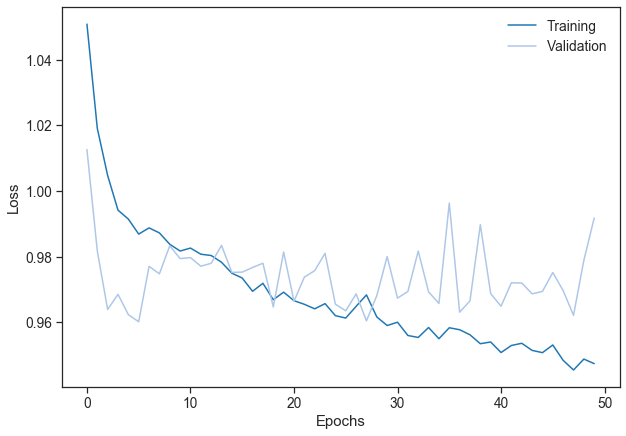

In [30]:
from src.utils.visualisation_utils import plot_loss_comparison

plot_loss_comparison(model.loss_during_training, model.valid_loss_during_training, figsize=(10,7))

##### Evaluation

In [31]:
# Read in the early-stopped model
model=torch.load(model_path+"earl_stp.pt")

* *Training set*

In [32]:
from sklearn.metrics import classification_report

y_true_tr, y_pred_tr, y_score_tr = model.predict_for_eval(train_loader)
print(classification_report(y_true_tr, y_pred_tr, target_names=["Negative", "Neutral", "Positive"], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.54      0.93      0.68      3995
     Neutral       0.50      0.01      0.03      1571
    Positive       0.41      0.14      0.21      2070

    accuracy                           0.53      7636
   macro avg       0.48      0.36      0.31      7636
weighted avg       0.50      0.53      0.42      7636



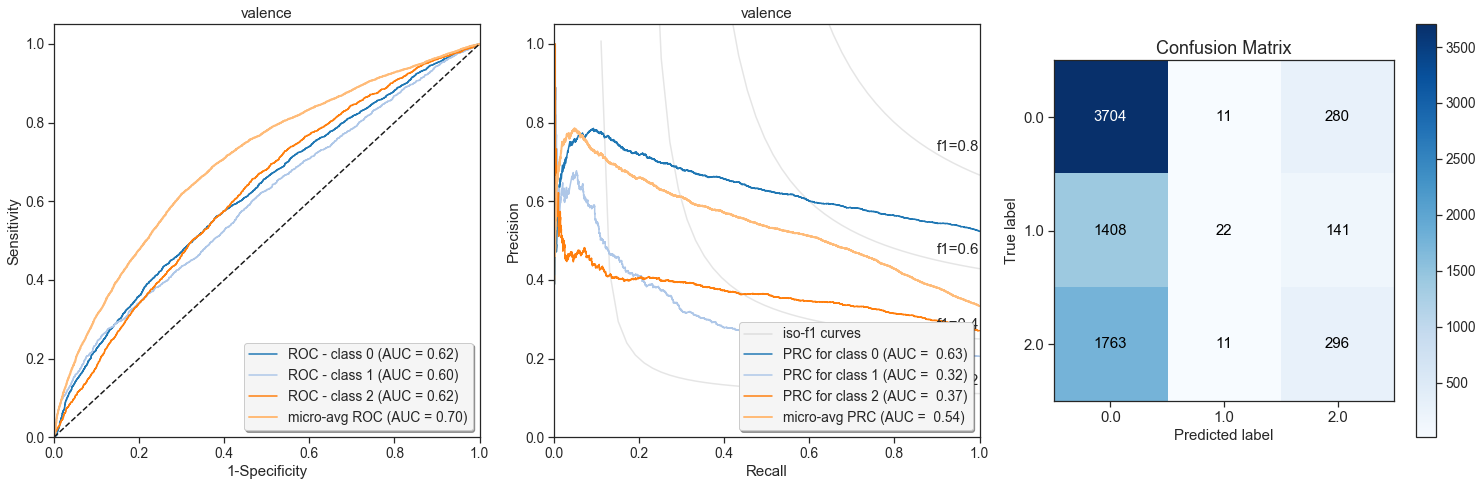

In [33]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_true_tr, y_pred_tr, y_score_tr, figsize=(21, 7), label="valence")

* *Test set*

In [34]:
from sklearn.metrics import classification_report

y_true, y_pred, y_score = model.predict_for_eval(test_loader)
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.57      0.85      0.68      1688
     Neutral       0.19      0.05      0.08       498
    Positive       0.29      0.12      0.17       814

    accuracy                           0.52      3000
   macro avg       0.35      0.34      0.31      3000
weighted avg       0.43      0.52      0.44      3000



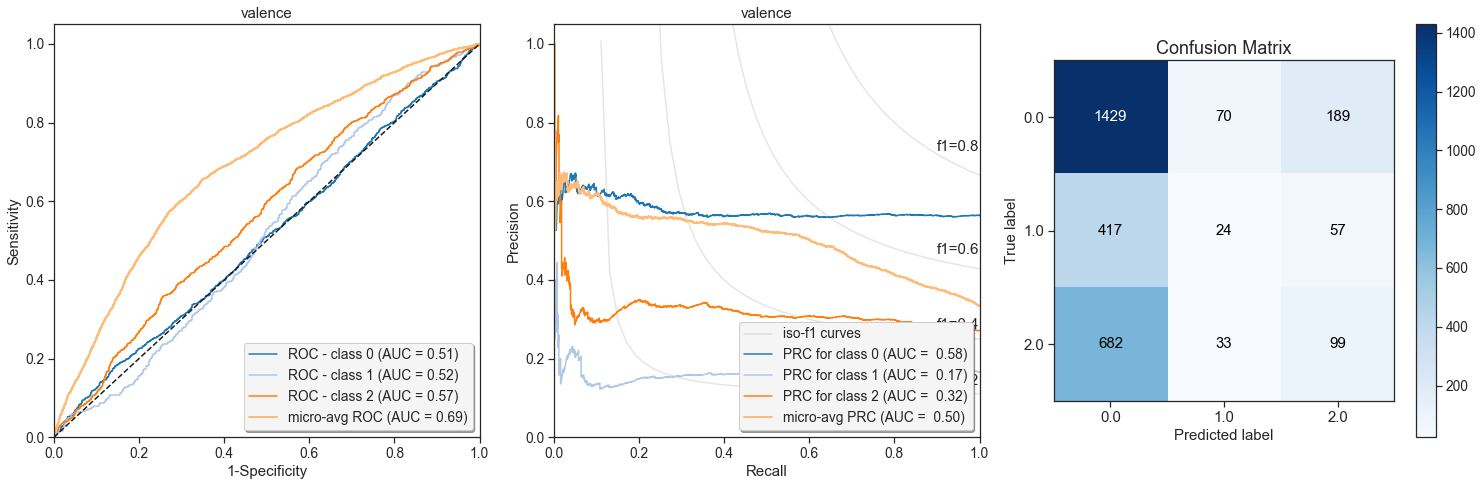

In [35]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_true, y_pred, y_score, figsize=(21, 7), label="valence")

### Prediction on MM posteriors

#### DataLoaders and Batching

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from src.utils.data_utils import VariableLengthCollator

# data loaders and batching
batch_size = 96

# create custom collator function
hmm_path = PATH_TO_HMM
my_collator = VariableLengthCollator(hmm_path, pad_token, add_posteriors=True, only_posteriors=True)

split_idx = int(0.9*len(df_train[0]))
train_loader = DataLoader(TensorDataset(df_train[0][:split_idx, :, :], df_train[1][:split_idx, :, :], df_train[2][:split_idx]),
                          shuffle=True, batch_size=batch_size, collate_fn=my_collator, drop_last=True, num_workers=16)
valid_loader = DataLoader(TensorDataset(df_train[0][split_idx:, :, :], df_train[1][split_idx:, :, :], df_train[2][split_idx:]),
                          shuffle=True, batch_size=batch_size, collate_fn=my_collator, drop_last=True, num_workers=16)
test_loader = DataLoader(TensorDataset(*df_test), batch_size=len(df_test[0]), collate_fn=my_collator, num_workers=16)

#### 1-layer, unidirectional GRU

##### Defining the Network

In [4]:
from src.models.cls.rnn_classifier import RNNExtended

# define dictionary of hyperparameters for the model
hparams = {
    "input_dim" : 7,
    "hidden_dim" : 64,
    "n_layers" : 1,
    "bidirectional" : False,
    "output_dim" : 3,
    "cell_type" : "GRU",
    "drop_prob" : 0,
    "learning_rate" : 0.001,
    "weight_decay" : 0,
    "max_nb_epochs" : 50,
    "clip" : 0.5,
    "pad_token" : pad_token,
}

# create a complete NN
model = RNNExtended(hparams)

print(model)

RNNExtended(
  (rnn): GRU(7, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


##### Training

In [5]:
model_path = PATH_TO_RNNs + '/gru_1l_only_post_'
model.train_loop(train_loader, valid_loader, print_every=10, model_path=model_path)
torch.save(model, model_path+'model.pt')

Epoch: 1	 Validation loss decreased (inf --> 1.0258).  Saving models ...
Epoch: 2	 Validation loss decreased (1.0258 --> 0.9996).  Saving models ...
Epoch: 3	 Validation loss decreased (0.9996 --> 0.9829).  Saving models ...
Epoch: 4	 Validation loss decreased (0.9829 --> 0.9797).  Saving models ...
Epoch: 5	 Validation loss decreased (0.9797 --> 0.9697).  Saving models ...
Epoch: 10/50	 Trn. Loss: 1.0105	 Trn. Acc: 52.32% 	 Val. Loss: 0.9764	 Val. Acc: 55.68%
Epoch: 20/50	 Trn. Loss: 1.0050	 Trn. Acc: 52.57% 	 Val. Loss: 0.9880	 Val. Acc: 55.01%
Epoch: 30/50	 Trn. Loss: 1.0062	 Trn. Acc: 52.44% 	 Val. Loss: 0.9940	 Val. Acc: 54.08%
Epoch: 40/50	 Trn. Loss: 1.0036	 Trn. Acc: 53.05% 	 Val. Loss: 0.9822	 Val. Acc: 55.25%
Epoch: 50/50	 Trn. Loss: 1.0003	 Trn. Acc: 53.43% 	 Val. Loss: 0.9850	 Val. Acc: 55.10%


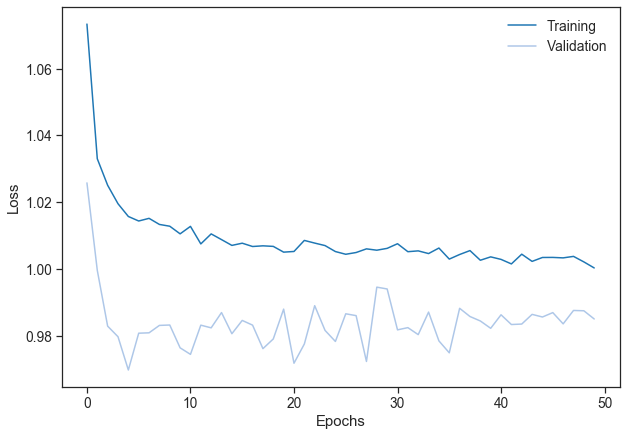

In [6]:
from src.utils.visualisation_utils import plot_loss_comparison

plot_loss_comparison(model.loss_during_training, model.valid_loss_during_training, figsize=(10,7))

##### Evaluation

In [7]:
# Read in the early-stopped model
model=torch.load(model_path+"earl_stp.pt")

* *Training set*

In [8]:
from sklearn.metrics import classification_report

y_true_tr, y_pred_tr, y_score_tr = model.predict_for_eval(train_loader)
print(classification_report(y_true_tr, y_pred_tr, target_names=["Negative", "Neutral", "Positive"], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.52      1.00      0.69      3995
     Neutral       0.00      0.00      0.00      1571
    Positive       0.00      0.00      0.00      2070

    accuracy                           0.52      7636
   macro avg       0.17      0.33      0.23      7636
weighted avg       0.27      0.52      0.36      7636



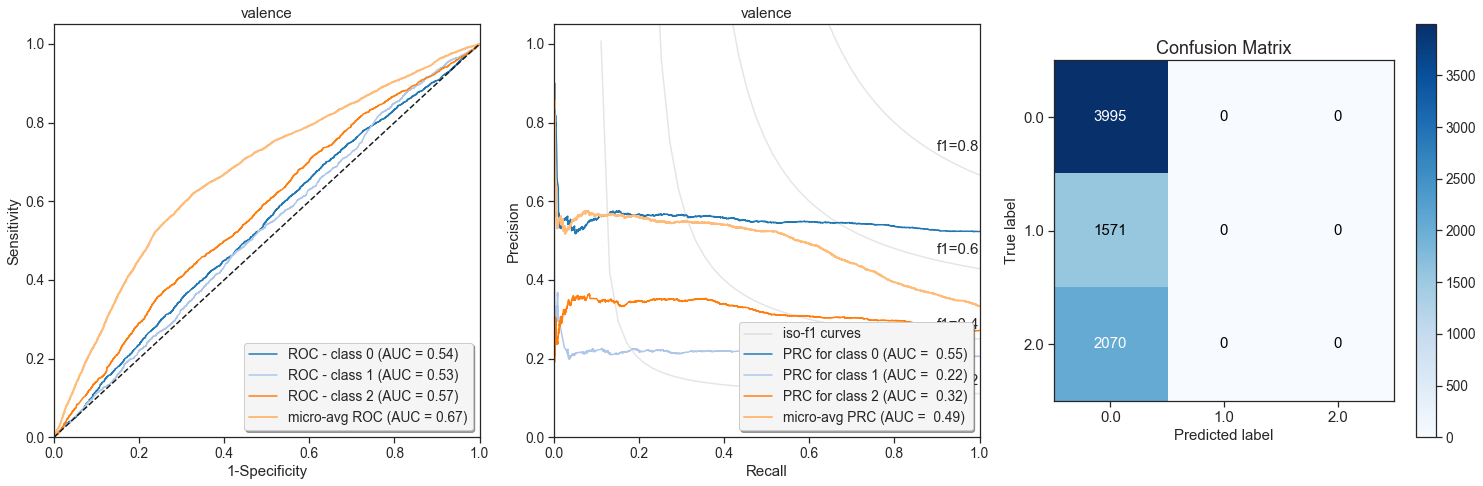

In [9]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_true_tr, y_pred_tr, y_score_tr, figsize=(21, 7), label="valence")

* *Test set*

In [10]:
from sklearn.metrics import classification_report

y_true, y_pred, y_score = model.predict_for_eval(test_loader)
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.56      1.00      0.72      1688
     Neutral       0.00      0.00      0.00       498
    Positive       0.00      0.00      0.00       814

    accuracy                           0.56      3000
   macro avg       0.19      0.33      0.24      3000
weighted avg       0.32      0.56      0.41      3000



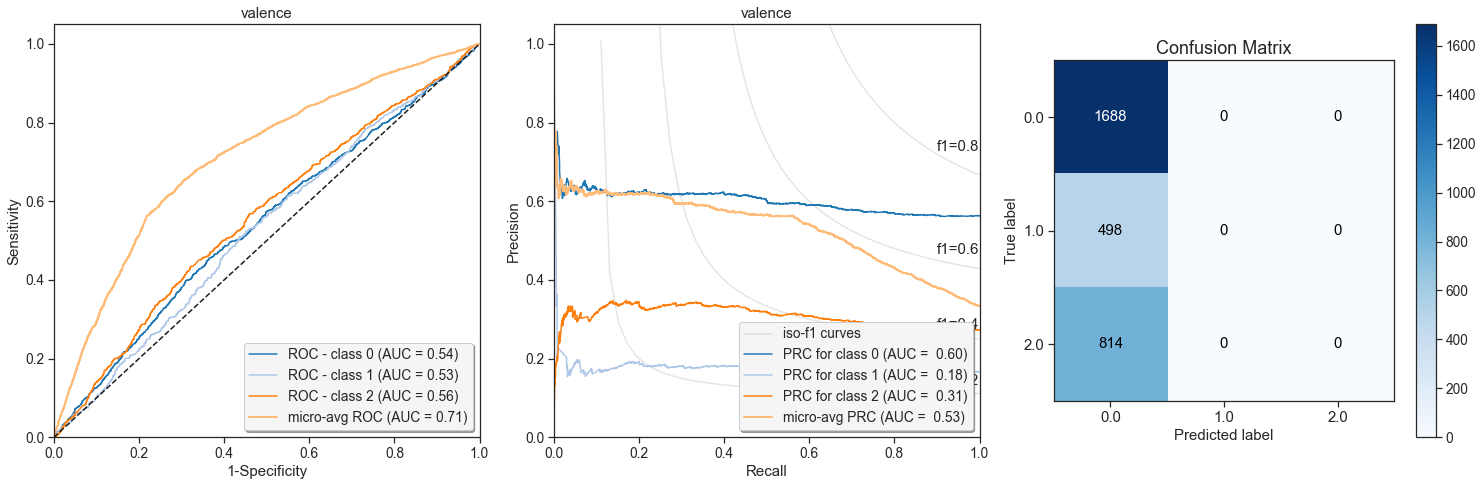

In [11]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_true, y_pred, y_score, figsize=(21, 7), label="valence")

### Prediction on raw data concatenated with MM posteriors

#### DataLoaders and Batching

In [36]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from src.utils.data_utils import VariableLengthCollator

# data loaders and batching
batch_size = 96

# create custom collator function
hmm_path = PATH_TO_HMM
my_collator = VariableLengthCollator(hmm_path, pad_token, add_posteriors=True)

split_idx = int(0.9*len(df_train[0]))
train_loader = DataLoader(TensorDataset(df_train[0][:split_idx, :, :], df_train[1][:split_idx, :, :], df_train[2][:split_idx]),
                          shuffle=True, batch_size=batch_size, collate_fn=my_collator, drop_last=True, num_workers=16)
valid_loader = DataLoader(TensorDataset(df_train[0][split_idx:, :, :], df_train[1][split_idx:, :, :], df_train[2][split_idx:]),
                          shuffle=True, batch_size=batch_size, collate_fn=my_collator, drop_last=True, num_workers=16)
test_loader = DataLoader(TensorDataset(*df_test), batch_size=len(df_test[0]), collate_fn=my_collator, num_workers=16)

#### 1-layer, unidirectional GRU

##### Defining the Network

In [37]:
from src.models.cls.rnn_classifier import RNNExtended

# define dictionary of hyperparameters for the model
hparams = {
    "input_dim" : 14,
    "hidden_dim" : 64,
    "n_layers" : 1,
    "bidirectional" : False,
    "output_dim" : 3,
    "cell_type" : "GRU",
    "drop_prob" : 0,
    "learning_rate" : 0.001,
    "weight_decay" : 0,
    "max_nb_epochs" : 50,
    "clip" : 0.5,
    "pad_token" : pad_token,
}

# create a complete NN
model = RNNExtended(hparams)

print(model)

RNNExtended(
  (rnn): GRU(14, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


##### Training

In [38]:
model_path = PATH_TO_RNNs + '/gru_1l_'
model.train_loop(train_loader, valid_loader, print_every=10, model_path=model_path)
torch.save(model, model_path+'model.pt')

Epoch: 1	 Validation loss decreased (inf --> 1.0876).  Saving models ...
Epoch: 2	 Validation loss decreased (1.0876 --> 1.0195).  Saving models ...
Epoch: 3	 Validation loss decreased (1.0195 --> 0.9892).  Saving models ...
Epoch: 4	 Validation loss decreased (0.9892 --> 0.9761).  Saving models ...
Epoch: 5	 Validation loss decreased (0.9761 --> 0.9721).  Saving models ...
Epoch: 10/50	 Trn. Loss: 0.9826	 Trn. Acc: 53.89% 	 Val. Loss: 0.9844	 Val. Acc: 53.97%
Epoch: 20/50	 Trn. Loss: 0.9728	 Trn. Acc: 54.55% 	 Val. Loss: 0.9722	 Val. Acc: 54.73%
Epoch: 23	 Validation loss decreased (0.9721 --> 0.9711).  Saving models ...
Epoch: 24	 Validation loss decreased (0.9711 --> 0.9558).  Saving models ...
Epoch: 30/50	 Trn. Loss: 0.9572	 Trn. Acc: 55.80% 	 Val. Loss: 0.9637	 Val. Acc: 55.32%
Epoch: 33	 Validation loss decreased (0.9558 --> 0.9542).  Saving models ...
Epoch: 37	 Validation loss decreased (0.9542 --> 0.9523).  Saving models ...
Epoch: 40/50	 Trn. Loss: 0.9457	 Trn. Acc: 55.54% 	

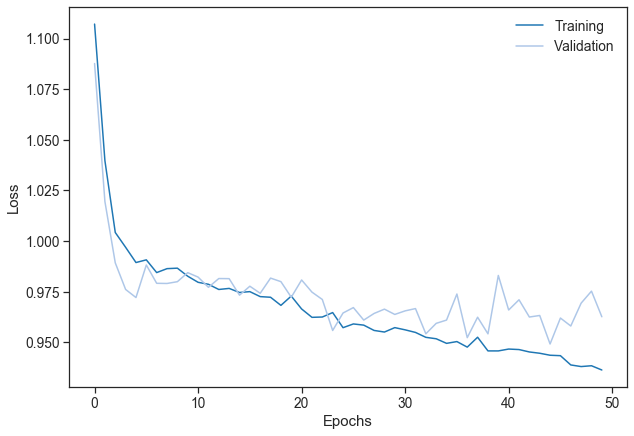

In [39]:
from src.utils.visualisation_utils import plot_loss_comparison

plot_loss_comparison(model.loss_during_training, model.valid_loss_during_training, figsize=(10,7))

##### Evaluation

In [40]:
# Read in the early-stopped model
model=torch.load(model_path+"earl_stp.pt")

* *Training set*

In [41]:
from sklearn.metrics import classification_report

y_true_tr, y_pred_tr, y_score_tr = model.predict_for_eval(train_loader)
print(classification_report(y_true_tr, y_pred_tr, target_names=["Negative", "Neutral", "Positive"], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.57      0.88      0.70      3995
     Neutral       0.59      0.12      0.21      1571
    Positive       0.50      0.28      0.36      2070

    accuracy                           0.56      7636
   macro avg       0.55      0.43      0.42      7636
weighted avg       0.56      0.56      0.50      7636



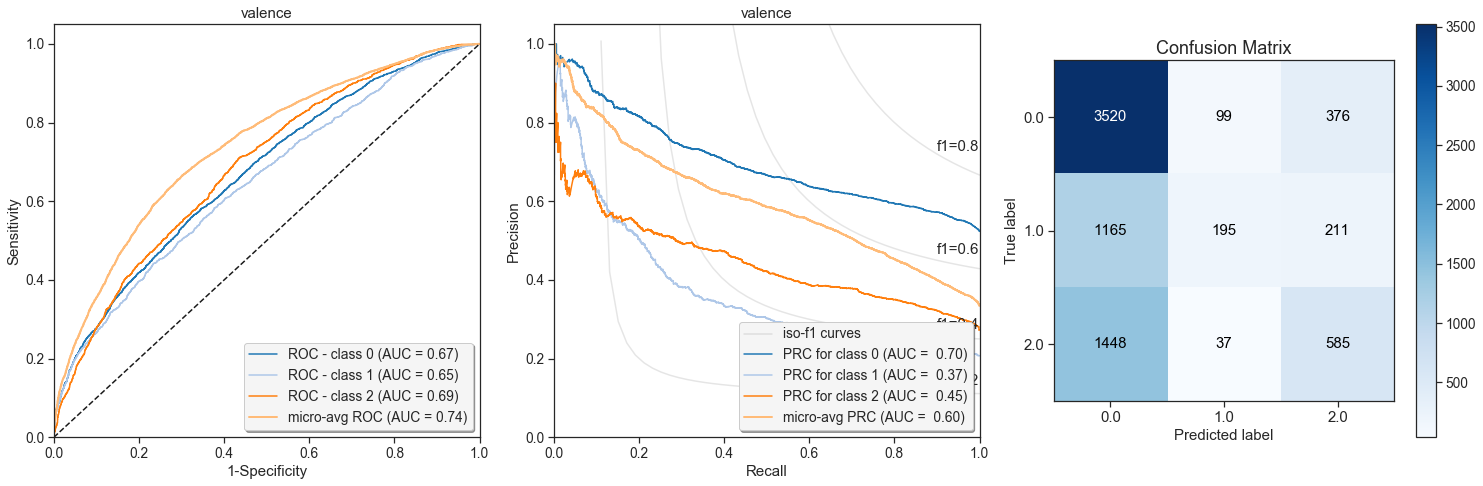

In [42]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_true_tr, y_pred_tr, y_score_tr, figsize=(21, 7), label="valence")

* *Test set*

In [43]:
from sklearn.metrics import classification_report

y_true, y_pred, y_score = model.predict_for_eval(test_loader)
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"], zero_division=0))

              precision    recall  f1-score   support

    Negative       0.57      0.79      0.66      1688
     Neutral       0.16      0.07      0.09       498
    Positive       0.41      0.22      0.29       814

    accuracy                           0.52      3000
   macro avg       0.38      0.36      0.35      3000
weighted avg       0.46      0.52      0.47      3000



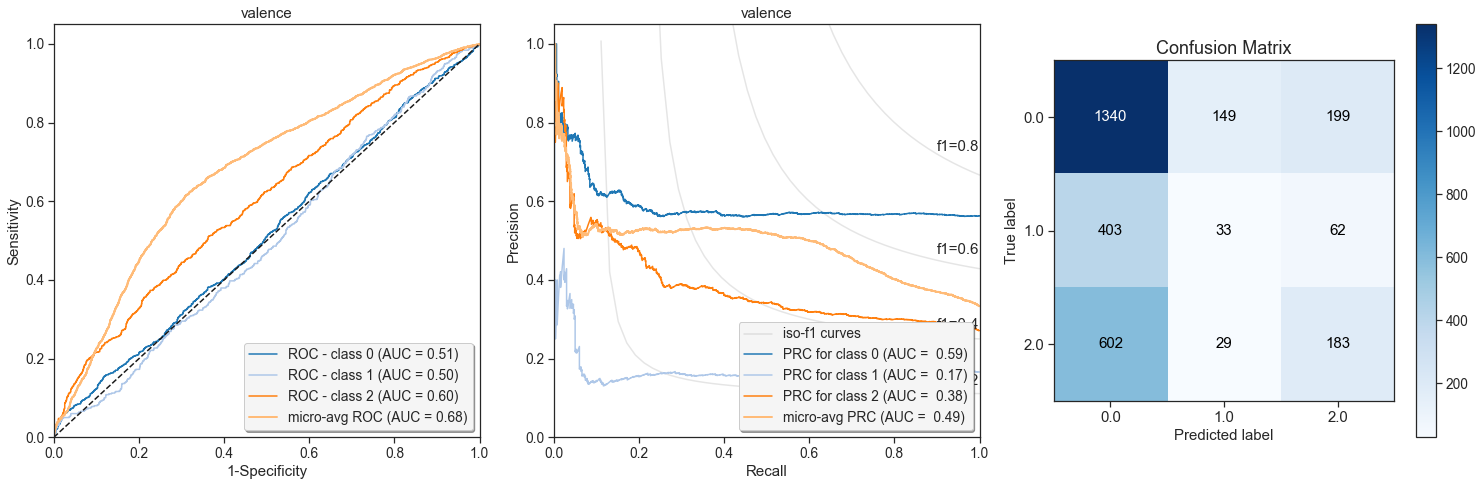

In [44]:
from src.utils.visualisation_utils import plot_evaluation

plot_evaluation(y_true, y_pred, y_score, figsize=(21, 7), label="valence")

## Personalised Models for Emotional Valence Prediction

All patients are used for training. The individual patient sequences are divided such that 80% of the patients'
observations is used for training, and the last 20% for testing. MM state posteriors of a single day of observation are used as input features.

We define a hierarchical Bayesian logistic regression with varying intercept model.
This model allows intercepts to vary across patients, according to a random effect. We just add a fixed slope for the predictor (i.e all patients will have the same slope):
> $y_i = Categorical(\alpha_{j[i]} + \beta x_{i})$

where the intercept random effect:
> $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$

We set a separate intercept for each patient, but rather than fitting separate
regression models for each patient, multilevel modelling shares strength among patients, allowing for more reasonable
inference in patients with little data. The model is trained with variational inference.

### Imputation and feature extraction

In [2]:
import pandas as pd
import multiprocessing as mp
from src.utils.data_utils import load_and_impute

# load training and test data
df_train = pd.read_csv(PATH_TO_TRAIN_DATA)
df_test = pd.read_csv(PATH_TO_TEST_DATA)

# list of input features
data_columns = ['steps_total', 'distance', 'sleep', 'app_usage', 'home_cluster', 'clusters_count', 'practiced_sport']

# impute missing values and get posteriors
hmm_path = PATH_TO_HMM
df_train_imp = load_and_impute(df_train, data_columns+['valence'], hmm_path, n_processes=mp.cpu_count(), dt=1, mix_mod=True)
df_test_imp = load_and_impute(df_test, data_columns+['valence'], hmm_path, n_processes=mp.cpu_count(), dt=1, mix_mod=True)

# concatenate the two data sets
data = pd.concat([df_train_imp, df_test_imp]).reset_index(drop=True).sort_values(by=['id', 'date'])

# list of classifier feature names
feature_columns = ['steps_total', 'distance', 'sleep', 'app_usage', 'home_cluster', 'clusters_count', 'practiced_sport']
state_columns = ['p(s_' + str(int(i)) + '|x_t)' for i in range(7)]

#### Train - Test split

In [3]:
from src.utils.data_utils import train_test_split

X_train, y_train, pidx_train, X_test, y_test, pidx_test, _ = train_test_split(
    data, state_columns, 'valence', p=0.2
)

print('x_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

# necessary variables for the model
patient_ids = data.id.unique()
n_classes = data.valence.nunique()
n_features = len(state_columns)
n_patients = len(patient_ids)

x_train shape:  (10045, 7)
y_train shape:  (10045,)
x_test shape:  (2938, 7)
y_test shape:  (2938,)


### Model definition

In [4]:
import pymc3 as pm
import theano
import theano.tensor as tt

# Reset training parameters
x_s = theano.shared(X_train)
y_s = theano.shared(y_train)
patient_idx = theano.shared(pidx_train)

alloc_diag = tt.nlinalg.AllocDiag()

with pm.Model() as vi_model:
    # Hyperpriors:
    a = pm.Normal('a', mu=0.0, sigma=10.0, shape=(n_classes,))
    sigma_a = pm.HalfNormal('sigma_a', sd=10.0, shape=(n_classes,))

    # Varying intercepts:
    a_patient = pm.MvNormal(
        'a_patient', mu=a, cov=alloc_diag(sigma_a), shape=(n_patients, n_classes)
    )

    # Common slope:
    b = pm.Normal('b', mu=0.0, sigma=10.0, shape=(n_features, n_classes))

    # Expected value per patient:
    mu = a_patient[patient_idx] + x_s.dot(b)

    p = tt.nnet.softmax(mu)

    y = pm.Categorical('y', p=p, observed=y_s)

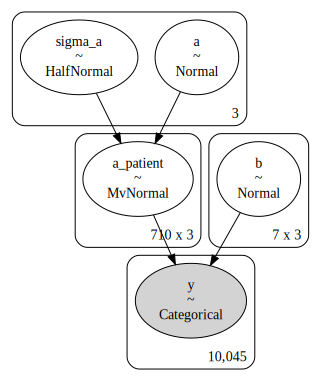

In [14]:
pm.model_to_graphviz(vi_model)

#### Training

In [6]:
with vi_model:
    # We'll use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(p, more_replacements={x_s: X_test,
                                                           patient_idx: pidx_test}, size=100)

    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

By applying the code above, we now have 100 sampled probabilities (default number for sample_node is None) for each
observation. Next we create symbolic expressions for sampled accuracy scores:

In [7]:
test_ok = tt.eq(test_probs.argmax(-1), y_test)
train_ok = tt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

Tracker expects callables so we can pass .eval method of theano node that is function itself.
Calls to this function are cached so they can be reused.

In [8]:
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval,
    train_accuracy=train_accuracy.eval
)

In [9]:
inference.fit(
    50,
    obj_optimizer=pm.adamax(learning_rate=0.1),
    callbacks=[eval_tracker, pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
);

#### Accuracy evolution plot

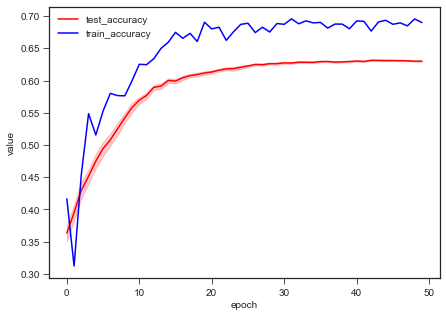

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(1, 1, figsize=(7,5))
df = pd.DataFrame(np.asarray(eval_tracker['test_accuracy'])).T.melt()
sns.lineplot(x='variable', y='value', data=df, color='red', ax=ax)
ax.plot(eval_tracker['train_accuracy'], color='blue')
ax.set_xlabel('epoch')
plt.legend(['test_accuracy', 'train_accuracy']);


### Trace plots
The posterior distribution of the parameters.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


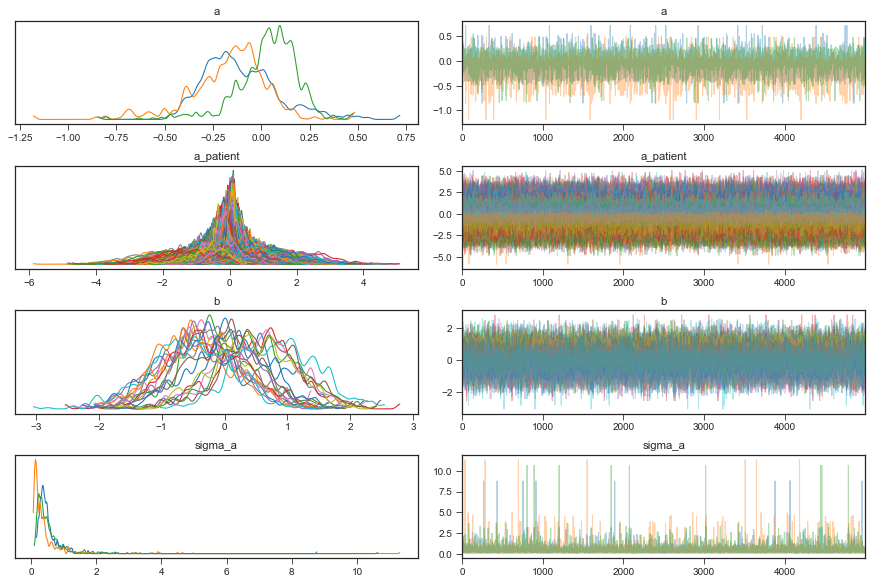

In [13]:
import arviz as az

trace = approx.sample(draws=5000)
axes = az.plot_trace(trace, compact=True)